<div style="text-align: right;">
<a target="_blank" href="https://colab.research.google.com/github/hkaragah/hkaragah.github.io/blob/main/earthquake/response_spectrum/response_spectrum.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
<div style="font-size: 0.8em; color: #555;">By Hossein Karagah</div>
<div style="font-size: 0.8em; color: #555;">© Copyright 2025 GNU GENERAL PUBLIC LICENSE.</div>
</div>

# Earthquake Response Spectrum

The earthquake response spectrum is a plot that shows the maximum response of a series of single-degree-of-freedom (SDOF) oscillators to a specific ground motion (earthquake acceleration record), as a function of the oscillator's natural period or frequency.

The response spectrum can be plotted for:
- Displacement spectrum: max. relative displacement ($u_{max}$) vs. oscillator's period
- Velocity spectrum: max. relative velocity ($\dot{u}_{max}$) vs. oscillator's period
- Acceleration spectrum: max. relative acceleration ($\ddot{u}_{max}$) vs. oscillator's period
- Pseudo-velocity spectrum: approxiamte max. velocity response ($\omega_n u_{max}$) vs. oscillator's period
- Pseudo-acceleration spectrum: aproximate max. acceleration respopnse ($\omega_n^2u_{max}$) vs. oscillator's period

Before dive into calculating the reponse spectrum, let's obtain an earthquke record. I use <a url="https://ngawest2.berkeley.edu/">PEER Ground Motion Database</a> and download an earthquake record including acceleration, velocity, and displacement time histories.

---

## Import Earthquake Record

The records I selected to work on here are named

- `RSN5970_SIERRA.MEX_BOR360.AT2`, 
- `RSN5970_SIERRA.MEX_BOR360.VT2`, 
- `RSN5970_SIERRA.MEX_BOR360.DT2`

representing acceleration, velocity, and displacement time histories of __2010 Baja California earthquake__, respectively. The earthquake had a moment magnitude of 7.2 $M_w$ and maximum Mercalli intensity of VII. The epicenter was located in south of Guadalupe Vistoria, Baja California, Mexico (32.286°N  115.295°W) at a depth of 10 km (6.2 mile).

<img src="../../assets/img/earthquake/response_spectrum/response_spectrum_02.png" alt="2010 Baja California earthquake">

Let's examine the first 10 lines of `RSN5970_SIERRA.MEX_BOR360.AT2` file.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import os
import sys
sys.path.append(os.path.abspath("../.."))
import assets.modules.earthquake as eq


In [43]:
file_path = "../../assets/data/earthquak/peer_records_raw/"

name_str = "RSN5970_SIERRA.MEX_BOR360"

file_names = {
    "Acceleration": name_str + ".AT2", 
    "Velocity": name_str + ".VT2", 
    "Displacement": name_str + ".DT2"
}

file_name = os.path.join(file_path, file_names["Acceleration"])
with open(file_name, 'r') as file:
    lines = file.readlines()

# Print the first 10 lines of the file
for i in range(10):
    print(lines[i].strip())
print("...")
    

PEER NGA STRONG MOTION DATABASE RECORD
El Mayor-Cucapah, 4/4/2010, Borrego Springs, 360
ACCELERATION TIME SERIES IN UNITS OF G
NPTS=  30296, DT=   .0100 SEC
-.3595791E-05  -.3602476E-05  -.3609122E-05  -.3614762E-05  -.3622277E-05
-.3629087E-05  -.3634954E-05  -.3641761E-05  -.3647513E-05  -.3656279E-05
-.3661616E-05  -.3667165E-05  -.3672715E-05  -.3675396E-05  -.3683046E-05
-.3685863E-05  -.3696702E-05  -.3703039E-05  -.3704650E-05  -.3707040E-05
-.3713379E-05  -.3714652E-05  -.3718122E-05  -.3746092E-05  -.3728889E-05
-.3744301E-05  -.3756375E-05  -.3747034E-05  -.3767861E-05  -.3751488E-05
...


---

The data starts from line 5, and there is one recording every 0.01 seconds as explained in the headline. Also, the acceleration data is recorded in $g$, and there are five acceleration values per line. Performing similar examination on the files with `.VT2` and `.DT2` shows that the velocity and displacement values are measured in cm/s, and cm, respectively. 

Using this information, I will parse the files as follows.

In [44]:
DT = float(lines[3].split()[-2])  # Sampling time interval in seconds
FIRST_LINE = 5  # First line to read in the file
g = 9.81 * 100 # gravitational acceleration (cm/s2)

time, ground, header = {}, {}, {}
for key, name in file_names.items():
    path = os.path.join(file_path, name)
    time[key], ground[key], header[key] = eq.read_values(path, DT, FIRST_LINE)

# Print the first 5 values of the time and ground values
print("First 10 values of time and ground values:\n")
print("Time (s)    Acceleration (g)    Velocity (cm/s)    Displacement (cm)")
for i in range(10):
    print(f"{time['Acceleration'][i]:8}    {ground['Acceleration'][i]:16}    "
          f"{ground['Velocity'][i]:15}    {ground['Displacement'][i]:15}")


First 10 values of time and ground values:

Time (s)    Acceleration (g)    Velocity (cm/s)    Displacement (cm)
     0.0       -3.595791e-06                0.0                0.0
    0.01       -3.602476e-06       -3.52895e-05      -1.764475e-07
    0.02       -3.609122e-06      -7.064436e-05      -7.061168e-07
    0.03       -3.614762e-06      -0.0001060594      -1.589636e-06
    0.04       -3.622277e-06       -0.000141539      -2.827628e-06
    0.05       -3.629087e-06      -0.0001770888      -4.420768e-06
    0.06       -3.634954e-06      -0.0002127008      -6.369716e-06
    0.07       -3.641761e-06      -0.0002483749      -8.675094e-06
    0.08       -3.647513e-06      -0.0002841106      -1.133752e-05
    0.09       -3.656279e-06      -0.0003199174      -1.435766e-05


---

Let's plot the recording for this earthquake.

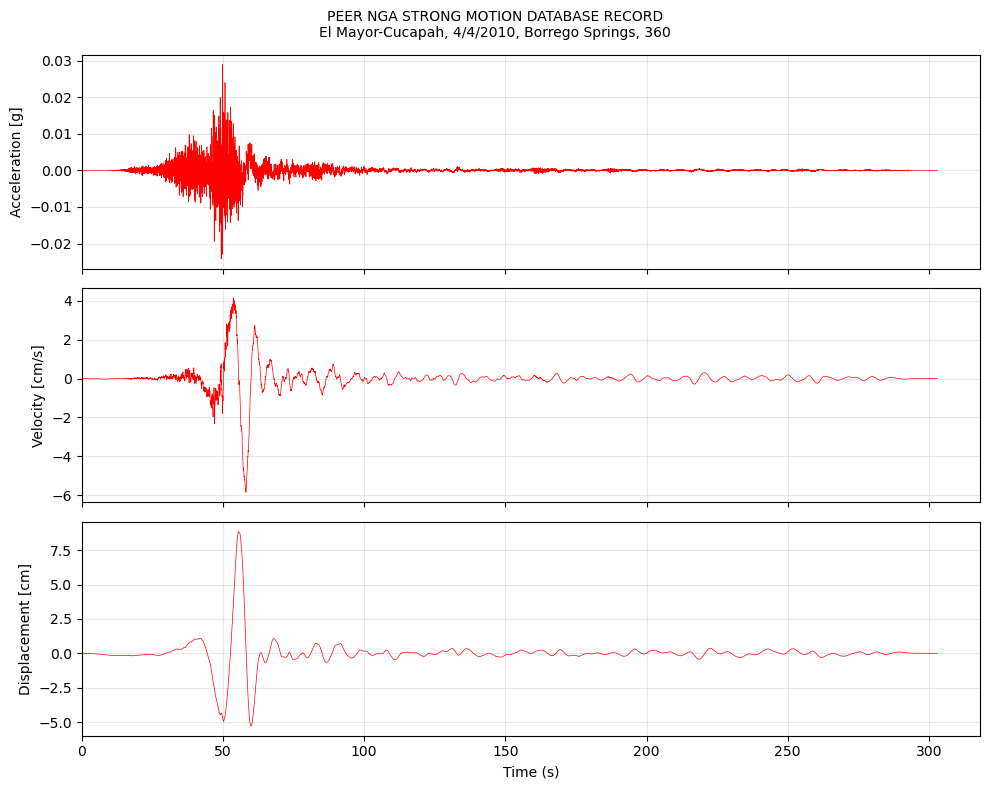

In [45]:
# Plot the earthquake records
plt.style.use('default')  # Use default style instead of seaborn
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(10, 8))

for i, key in enumerate(ground.keys()):
    ax[i].plot(time[key], ground[key], 'r-', label=key, linewidth=0.5)
    ax[i].set_ylabel(f'{key} [{header[key][-2].split()[-1].lower()}]')
    ax[i].grid(True, alpha=0.3)
    ax[i].set_xlim(left=0)

ax[-1].set_xlabel('Time (s)')
title_lines = list(header.values())[0]
plt.suptitle(f"{title_lines[0]}\n{title_lines[1]}", fontsize=10)
plt.tight_layout()
plt.show()

---

Usually recording devices records the ground acceleration, and the velocity and displacement are computed. To perform a quick check on the downloaded data, I will compute the velocity and displacement by integrating the acceleration using the trapizoid rule. Comparing the plots shows that computed velocity and displacement time histories closely follows the downloaded records.

In [46]:
# Compute the velocity and displacement from acceleration
acc = ground['Acceleration'] * g # ground acceleration in cm/s^2
vel, disp = eq.integrate_acceleration(acc, DT, 1, baseline_correction=False, highpass_filter=False)


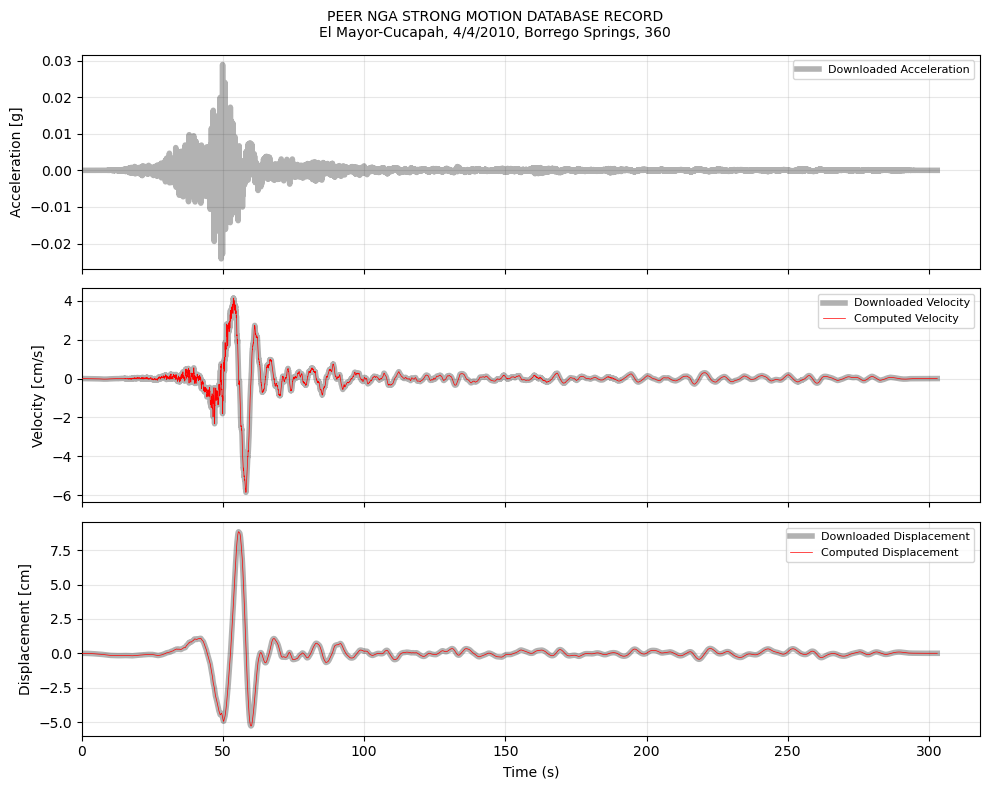

In [47]:
# Plot the earthquake records
plt.style.use('default')  # Use default style instead of seaborn
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(10, 8))

for i, key in enumerate(ground.keys()):
    ax[i].plot(time[key], ground[key], 'k-', alpha=0.3, label=f"Downloaded {key}", linewidth=4)
    if key == 'Velocity':
        ax[i].plot(time['Acceleration'], vel, 'r-', label='Computed Velocity', linewidth=0.5, zorder=10)
    elif key == 'Displacement':
        ax[i].plot(time['Acceleration'], disp, 'r-', label='Computed Displacement', linewidth=0.5, zorder=10)
    ax[i].set_ylabel(f'{key} [{header[key][-2].split()[-1].lower()}]')
    ax[i].grid(True, alpha=0.3)
    ax[i].set_xlim(left=0)
    ax[i].legend(loc='upper right', fontsize=8)

ax[-1].set_xlabel('Time (s)')
title_lines = list(header.values())[0]
plt.suptitle(f"{title_lines[0]}\n{title_lines[1]}", fontsize=10)
plt.tight_layout()
plt.show()


---

### Frequency content

The frequency content of an earthquake record describes how much energy is present at different frequencies in the ground motion. It tells us which frequencies dominate the shaking, and it’s crucial for understanding how structures will respond. If the earthquake has a lot of energy near that frequency, resonance can occur → severe damage. The main ways to describe the frequency content of a ground acceleration time history $\ddot{u_g}$ are as follows.


1. __Fourier Transform / Amplitude Spectrum:__Breaks the ground motion into sine waves of different frequencies. The result would be a plot of amplitude vs. frequency. It explains how much energy exists at each frequency.

$$FT[\ddot{u_g}(t)]=\int_{-\infty}^{\infty} \ddot{u_g}(t)\exp^{-i\omega t}dt$$

2. __Power Spectral Density (PSD):__ Shows energy distribution over frequency. Its plot is smoother and better for statistical or random processes.

3. __Response Spectrum:__ Indirectly reflects frequency content by plotting maximum response of SDOF systems across a range of frequencies. Peaks in the response spectrum correspond to strong frequency components in the ground motion.

4. __Wavelet Transform__ It is similar to Fourier Transform, but gives time and frequency information. It is useful because earthquake frequency content changes over time.

---

Applying the _Fourier Transform_ to the acceleration record shows that the range of the dominant frequencies are mostly within the smaller frequecy values, especially between 0.05 Hz and 0.20 Hz. This range is correspond to oscillation periods ranging from 5 to 20 seconds.



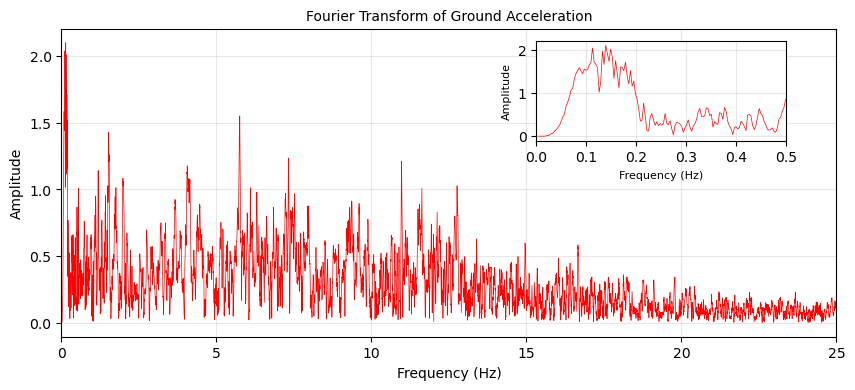

In [48]:
# Calculate frequency content using FFT
n = len(ground['Acceleration'])
freq = np.fft.fftfreq(n, DT)  # frequency array
fft_acc = np.fft.fft(ground['Acceleration'])  # FFT of acceleration
fft_magnitude = np.abs(fft_acc)  # magnitude spectrum

# Plot frequency content
plt.figure(figsize=(10, 4))
plt.plot(freq[1:n//2], fft_magnitude[1:n//2], 'r-', linewidth=0.5)
plt.grid(True, alpha=0.3)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Fourier Transform of Ground Acceleration', fontsize=10)
plt.xlim(0, 25)  # Limit x-axis to 25 Hz which covers most seismic frequencies

# Add inset axes for zoomed plot
axins = plt.axes([0.6, 0.6, 0.25, 0.25])  # [x, y, width, height]
axins.plot(freq[1:n//2], fft_magnitude[1:n//2], 'r-', linewidth=0.5)
axins.set_xlim(0, 0.5)  # Zoom to 0-0.5 Hz range
axins.set_xlabel('Frequency (Hz)', fontsize=8)
axins.set_ylabel('Amplitude', fontsize=8)
axins.grid(True, alpha=0.3)
plt.show()


## Power Spectral Density (PSD)

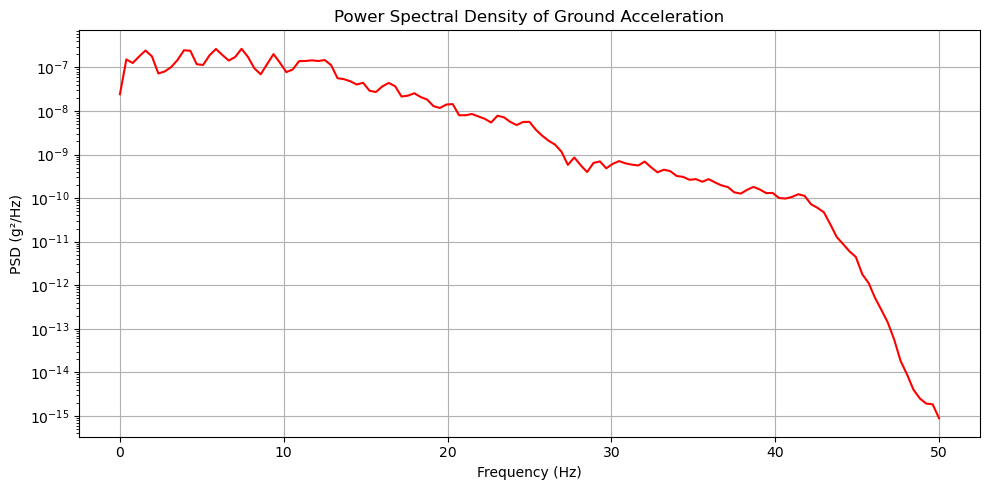

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

fs = 1 / DT  # Sampling frequency in Hz

# Compute Power Spectral Density using Welch's method
frequencies, psd = welch(ground['Acceleration'], fs=fs, nperseg=256)

# Plot PSD
plt.figure(figsize=(10, 5))
plt.semilogy(frequencies, psd, 'r') # log-scale for y-axis
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (g²/Hz)' if ground['Acceleration'].max() < 5 else 'PSD (units²/Hz)')
plt.title('Power Spectral Density of Ground Acceleration')
plt.grid(True)
plt.tight_layout()
plt.show()


## Continuous Wevelet Transformation (CWT)

The wavelet transform is a powerful mathematical tool used to analyze non-stationary signals — i.e., signals whose frequency content changes over time (like earthquakes, ECGs, speech). Unlike the Fourier transform, which provides a global frequency breakdown, the wavelet transform gives a time–frequency representation.

Instead of using infinite-length sinusoids (like in Fourier), the wavelet transform uses short, localized waveforms called wavelets that are:

* Oscillatory
* Localized in both time and frequency
* Scaled (stretched/compressed) and shifted (moved) to analyze different parts of the signal

---

### Formulation

Given an earthquake acceleration $\ddot u_g(t)$, the CWT is defined as

$$W(a,b)=\int_{-\infty}^{\infty}\ddot u_g(t)\cdot\psi^*\left(\frac{t-b}{a}\right)dt$$

where:
- $W(a, b)$ is the wavelet coefficient at scale $a$ and time shift $b$
- $\psi(t)$ is the mother wavelet (e.g., Morlet or Ricker)
- $\psi^*$ is the complex conjugate of the wavelet
- $a$ is the scale (inverse of frequency), low $a$ corresponds to high frequency and high $a$ corresponds to low frequency
- $b$ is the translation (time shift)

---

The wavelet is scaled and shifted, and convolved with the signal $\ddot u_g(t)$, producing coefficients that represent how much of the wavelet is present at each time and scale. In the resulting 2D array of wavelet coefficients $W(a,b)$:

- Rows represent different scales
- Columns represent diferent time

The magnitude, $|W(a, b)|$, shows how strong the signal is at scale $a$ and time $b$. the scale can be converted to frequency using

$$f=\frac{f_c}{a \cdot \Delta t}$$

where:

- $f_c$ is the cenbter frequency of the wavelet (e.g., 0.8125 for Morlet)
- $\Delta t$ is the sampling interval
- $a$ is the scale.

In earthquake analysis, the CWT helps to identify

* Arrival time of different waves (i.e., P-wave, S-wave, Surface wave)
* Frequency bursts due to damage or phase transitions
* Energy concentration over time

---


### Common Wavelets

1. __Morlet Wavelet__

    A complex sinusoid (cosine + sine) modulated by Gaussian envelope:

    $$\psi(t)=\pi^{-1/4}e^{i\omega_0t}e^{-t^2/2}$$

    where $\omega_0$ is the central frequency (often 5-6).

    Characteristics:

    - Complex-valued: gives both magnitude and phase
    - Good frequency resolution
    - Tunable time–frequency balance via $\omega_0$
    - Produces smooth, continuous time–frequency maps
    - Can easily be used to calculate power spectra or instantaneous phase

    Use cases:

    - Time–frequency analysis
    - Continuous wavelet transform (CWT)
    - Earthquake, speech, EEG, and vibration signals



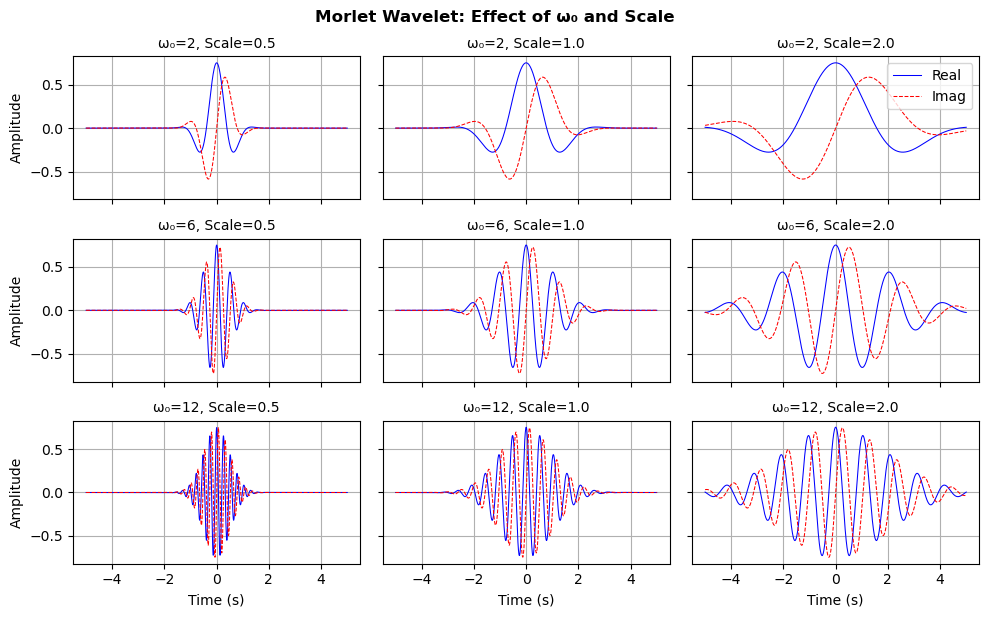

In [50]:
def morlet_wavelet(t, scale=1.0, omega0=6.0):
    return np.pi**(-0.25) * np.exp(1j * omega0 * t / scale) * np.exp(-t**2 / (2 * scale**2))


TMIN, TMAX, NPOINTS = -5, 5, 1000
t = np.linspace(TMIN, TMAX, NPOINTS)
OMEGA0 = [2, 6, 12]
SCALES = [0.5, 1.0, 2.0]


fig, axes = plt.subplots(len(OMEGA0), len(SCALES), figsize=(10, 6), sharex=True, sharey=True)

for i, omega0 in enumerate(OMEGA0):
    for j, scale in enumerate(SCALES):
        wavelet = morlet_wavelet(t, scale=scale, omega0=omega0)
        ax = axes[i, j]
        ax.plot(t, np.real(wavelet), label='Real', color='blue', linewidth=0.75)
        ax.plot(t, np.imag(wavelet), label='Imag', color='red', linewidth=0.75, linestyle='--')
        ax.set_title(f'ω₀={omega0}, Scale={scale}', fontsize=10)
        ax.grid(True)
        if i == len(OMEGA0) - 1:
            ax.set_xlabel("Time (s)")
        if j == 0:
            ax.set_ylabel("Amplitude")

axes[0, -1].legend(loc='upper right')

plt.tight_layout()
plt.suptitle("Morlet Wavelet: Effect of ω₀ and Scale", fontsize=12, fontweight='bold', y=1.02)
plt.show()


2. __Ricker Wavelet (aka. Mexican Hat)__

    It is defined as the 2nd-derivative of a Gaussian, real-valued only:

    $$\psi(t)=\frac{2}{\sqrt{3}\pi^{1/4}}\left(1-t^2\right)e^{-t^2/2}$$

    and the scaled wavelet is given by

    $$\psi_s(t)=\frac{1}{\sqrt{s}}\psi\left(\frac{t}{s}\right)$$

    Characteristics:
    - Real-valued, thus no phase information
    - Symmetric, impulse-like shape
    - Excellent localization in time
    - Good for detecting short bursts (impulse arrivals)

    Use cases:
    - Seismology: modeling source time functions
    - Synthetic seismic data generation
    - Detection of P-wave or S-wave arrivals
    - More common in discrete time signal generation than full spectral analysis

    Limitation in your case:
    - Not ideal for CWT-based time–frequency mapping
    - Since it lacks phase and is non-complex, it doesn't allow detailed spectral analysis or clean power plots

    Below, I define a function to compute the normalized amplitudes of the Ricker (Mexican Hat) wevelet, and then plot the function for different scale factor. As shown, wavelet is stretched along the time axis when the scale factor is greater than one, and compressed when it is less than one.

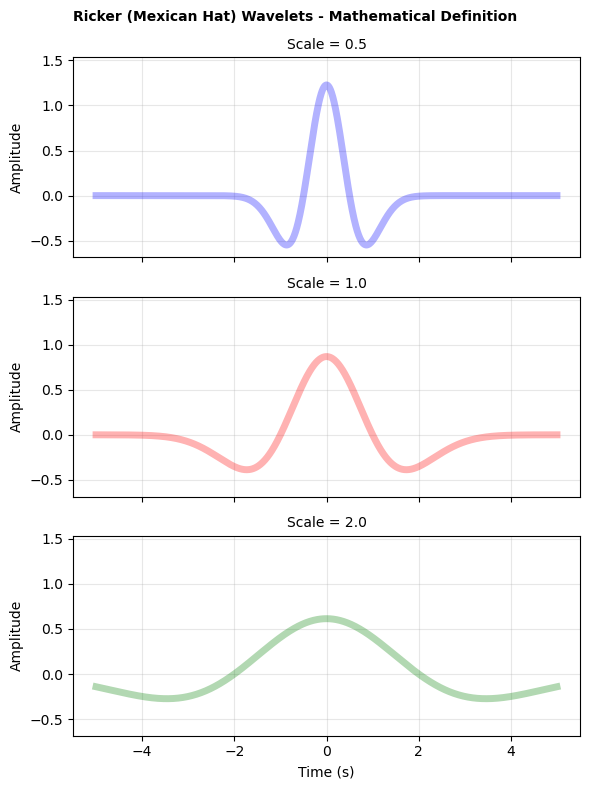

In [51]:
def mexican_hat_mathematical(t, scale=1):
    """
    Mathematical definition of Mexican Hat (Ricker) wavelet
    ψ(t) = (2/√3π^(1/4)) * (1 - t²) * exp(-t²/2)
    """
    t_scaled = t / scale  # Scale the time vector
    coefficient = 2 / (np.sqrt(3) * np.pi**(1/4))
    wavelet = coefficient * (1 - t_scaled**2) * np.exp(-t_scaled**2 / 2)
    return wavelet / np.sqrt(scale) # Normalize by scale factor


COLORS = ['blue', 'red', 'green']

# Define time base
t = np.linspace(TMIN, TMAX, NPOINTS)

a_min, a_max = [], []

fig, ax = plt.subplots(len(SCALES), 1, sharex=True, figsize=(6, 8))

for i, scale in enumerate(SCALES):
    wavelet = mexican_hat_mathematical(t, scale=scale)
    
    a_min.append(np.min(wavelet))
    a_max.append(np.max(wavelet))
    
    ax[i].plot(t, wavelet, color=COLORS[i], label=f'Scale: {scale}', linewidth=5, alpha=0.3)
    
    ax[i].set_ylabel('Amplitude')
    ax[i].set_title(f"Scale = {scale}", fontsize=10)
    ax[i].grid(True, alpha=0.3)
    ax[-1].set_xlabel('Time (s)')

for i in range(len(SCALES)):
    ax[i].set_ylim(1.25*min(a_min), 1.25*max(a_max))
    
fig.suptitle('Ricker (Mexican Hat) Wavelets - Mathematical Definition', fontsize=10, fontweight='bold')
plt.tight_layout()
plt.show()

Let's also use <a ref="https://pywavelets.readthedocs.io/en/latest/">PyWavelets module (`pywt`)</a> to plot this wavelet and compare it to the function that I defined above. The plots shows that the normalized wavelet obtained from `mexican_hat_pywt` and `mexican_hat_mathematical` are in agrrement.

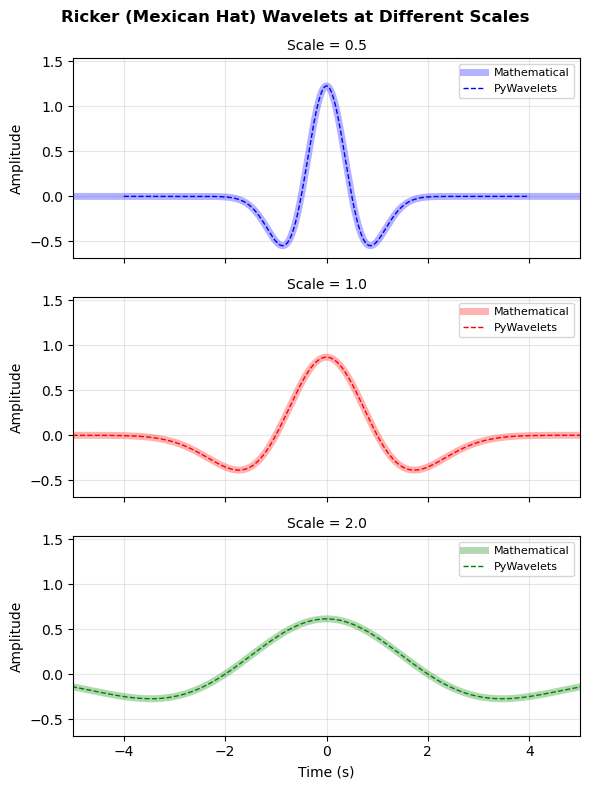

In [52]:
import pywt


def mexican_hat_pywt(scale=1):
    wavelet_func = pywt.ContinuousWavelet('mexh')
    psi, t = wavelet_func.wavefun(length=NPOINTS)
    t = t * scale  # Scale the time vector
    psi_normalized = psi / np.sqrt(scale)  # Normalize amplitude
    return t, psi_normalized


a_min, a_max = [], []

fig, ax = plt.subplots(len(SCALES), 1, sharex=True, figsize=(6, 8))

for i, scale in enumerate(SCALES):
    wavelet_math = mexican_hat_mathematical(t, scale=scale)
    t_pywt, wavelet_pywt = mexican_hat_pywt(scale=scale)

    a_min.append(min(np.min(wavelet_math), np.min(wavelet_pywt)))
    a_max.append(max(np.max(wavelet_math), np.max(wavelet_pywt)))
    
    ax[i].plot(t, wavelet_math, color=COLORS[i], linewidth=5.0, alpha=0.3, label=f'Mathematical')
    ax[i].plot(t_pywt, wavelet_pywt, '--', color=COLORS[i], linewidth=1.0, label=f'PyWavelets')
    
    ax[i].set_xlim(TMIN, TMAX)
    ax[i].set_ylabel('Amplitude')
    ax[i].set_title(f"Scale = {scale}", fontsize=10)
    ax[i].grid(True, alpha=0.3)
    ax[i].legend(fontsize=8)


for i in range(len(SCALES)):
    ax[i].set_ylim(1.25*min(a_min), 1.25*max(a_max))

ax[-1].set_xlabel('Time (s)')
fig.suptitle('Ricker (Mexican Hat) Wavelets at Different Scales', fontsize=12, fontweight='bold')
fig.tight_layout()
plt.show()


In [53]:
# from mpl_toolkits.axes_grid1 import make_axes_locatable


# # Create a test signal with multiple frequency components
# t_signal = np.linspace(0, 1, 1000)
# dt = t_signal[1] - t_signal[0]  # Time step
# signal = (np.sin(2 * np.pi * 20 * t_signal) * np.exp(-10 * t_signal) +
#           np.sin(2 * np.pi * 20 * t_signal) * (t_signal > 0.5))

# # Perform continuous wavelet transform
# scales_cwt = np.arange(1, 31)
# coefficients, frequencies = pywt.cwt(signal, scales_cwt, 'mexh', sampling_period=dt)

# # Create figure with 3 subplots
# fig, ax = plt.subplots(3, 1, sharex=True, figsize=(8, 8), gridspec_kw={'height_ratios': [1, 1, .1]})

# # Subplot 1: Original signal
# ax[0].plot(t_signal, signal, 'b-', linewidth=2)
# ax[0].set_title('Original Signal', fontsize=12)
# ax[0].set_ylabel('Amplitude')
# ax[0].grid(True, alpha=0.3)

# # Subplot 2: CWT scalogram (no colorbar here)
# im = ax[1].imshow(np.abs(coefficients), aspect='auto', cmap='jet',
#                   extent=[t_signal[0], t_signal[-1], scales_cwt[-1], scales_cwt[0]])
# ax[1].set_title('Continuous Wavelet Transform (Mexican Hat)', fontsize=12)
# ax[1].set_ylabel('Scale')

# # Subplot 3: Empty, used only for horizontal colorbar
# ax[2].axis('off')
# divider = make_axes_locatable(ax[2])
# cax = divider.append_axes("bottom", size="100%", pad=0.0)  # no padding
# fig.colorbar(im, cax=cax, orientation='horizontal', label='|CWT Coefficients|')

# # Match x-limits and ticks
# ax[1].set_xlim(t_signal[0], t_signal[-1])
# ax[0].set_xlim(t_signal[0], t_signal[-1])
# xticks = np.linspace(t_signal[0], t_signal[-1], 6)
# ax[0].set_xticks(xticks)
# ax[1].set_xticks(xticks)

# fig.tight_layout()
# plt.show()


3. __Daubechies Wavelets__

    Family of orthogonal wavelets with compact support and asymmetry.
    - The wavelet functions and their shifts are mathematically orthogonal, i.e.

    $$\left<\psi(t-n), \psi(t-m)\right>=0\ \text{for}\ n\neq m$$

    - The wavelet function is zero outside a finite interval.
    - The wavelet shape is not symmetric (i.e., not an even function)

    Characteristics:
    - Designed for Discrete Wavelet Transform (DWT), not CWT
    - No analytical expression
    - Indexed by number of vanishing moments (e.g., db2, db4). Vanishing moments is the maximum polynomial degree that the wavelet is orthogonal to. A wavelet, $\psi(t)$, has $N$ vanishing moments if:
    
    $$\int_{-\infty}^{\infty} t^k\psi(t)dt=0\ \text{for}\ k=0, 1, 2, ..., N-1$$

    For instance, db2 has two vanishing moments, meaning that it is orthogonal to constants and linear trends.

    Use cases:
    - Signal compression
    - Denoising
    - Structural damage detection
    - Multiresolution analysis

    _Symlets_ or _Coiflets_ are variants of _Daubechies_ with improved symmetry. They are mostly used in DWT, image compression, and signal feature extraction.

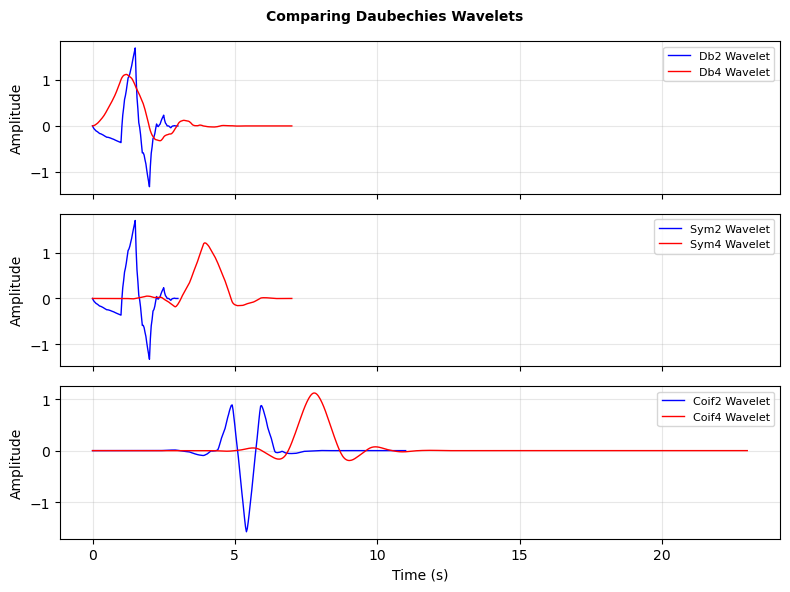

In [54]:
import pywt


TYPES = [['db2', 'db4'], ['sym2', 'sym4'], ['coif2', 'coif4']]

fig, ax = plt.subplots(len(TYPES), 1, figsize=(8, 6), sharex=True)

for i, type in enumerate(TYPES):
    wavelet0 = pywt.Wavelet(type[0])
    wavelet1 = pywt.Wavelet(type[1])
    phi0, psi0, x0 = wavelet0.wavefun(level=5)
    phi1, psi1, x1 = wavelet1.wavefun(level=5)

    ax[i].plot(x0, psi0, label=f'{type[0].capitalize()} Wavelet', linewidth=1, color='blue')
    ax[i].plot(x1, phi1, label=f'{type[1].capitalize()} Wavelet', linewidth=1, color='red')

    ax[i].set_ylabel('Amplitude')
    ax[i].legend(fontsize=8)
    ax[i].grid(True, alpha=0.3)

ax[-1].set_xlabel('Time (s)')
plt.suptitle('Comparing Daubechies Wavelets', fontsize=10, fontweight='bold')
plt.tight_layout()
plt.show()


---

Considering the use cases of each wavelet, the Morlet wavelet is utilized for the transformation. The CWT is plotted as a scalogram (spectrum power spectrum), where the colors represet the range of power, $|W(a, b)|^2$. The scalogram shows that most of the energy (bright red bands) is concentrated between 45 to 55 seconds. It also reveals that the dominant frequencies are capped at around 20 Hz, which is consistent with the results obtain from FFT and PSD.

In [67]:
import pywt

# Estimate target frequency range (e.g., 0.1–80 Hz)
f_min = 0.1  # Hz
f_max = 80   # Hz
num_freqs = 500

# Sampling interval
dt = DT

# Define frequency array and compute corresponding scales for Morlet
frequencies = np.linspace(f_min, f_max, num_freqs)
scales = pywt.central_frequency('morl') / (frequencies * dt)

# Perform wavelet transform
coefficients, freqs = pywt.cwt(ground['Acceleration'], scales, 'morl', sampling_period=dt)

# Compute wavelet power (suppress sign and emphasize persistent energy)
power = np.abs(coefficients) ** 2

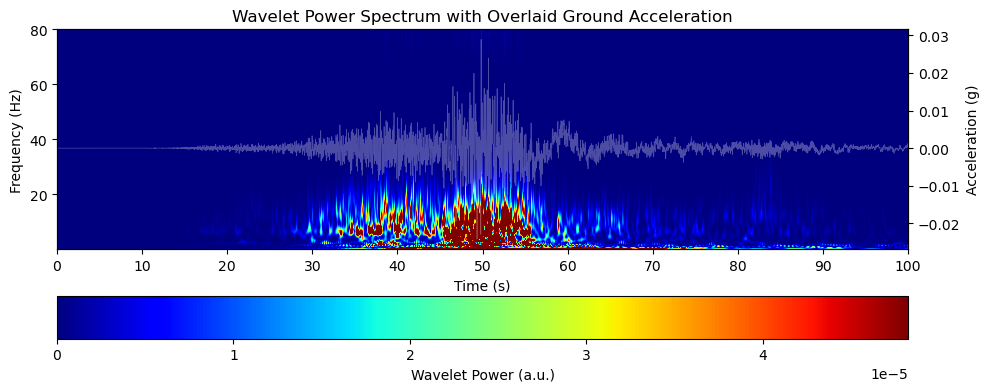

In [68]:
# Plot wavelet power spectrum
fig, ax1 = plt.subplots(figsize=(10, 4))
img = ax1.imshow(
    power,
    extent=[time['Acceleration'][0], time['Acceleration'][-1], frequencies[-1], frequencies[0]],
    cmap='jet',
    aspect='auto',
    vmin=0,           # Set min to zero
    vmax=np.percentile(power, 99.5)  # Clip upper limit at the 99.5th percentile
)


ax1.set_ylabel('Frequency (Hz)')
ax1.set_xlabel('Time (s)')
ax1.set_title('Wavelet Power Spectrum with Overlaid Ground Acceleration')
ax1.set_xlim(0, 100)
ax1.set_xticks(np.arange(0, 101, 10))
ax1.set_ylim(frequencies[0], frequencies[-1])  # low freq at bottom

# Add colorbar
cbar = fig.colorbar(img, ax=ax1, orientation='horizontal', pad=0.15)
cbar.set_label('Wavelet Power (a.u.)')

# Overlay original acceleration signal
ax2 = ax1.twinx()
ax2.plot(time['Acceleration'], ground['Acceleration'], 'w-', linewidth=0.5, alpha=0.3)
ax2.set_ylabel('Acceleration (g)', color='k')
ax2.tick_params(axis='y', labelcolor='k')

plt.tight_layout()
plt.show()


## SDOF Influenced by Ground Motion: Equation of Motion


<img src="../../assets/img/earthquake/response_spectrum/response_spectrum_01.jpg" alt="SDOF under groud motion" width=600>

The equation of motion for a Single Degree of Freedom (SDOF) system subjected to ground motion acceleration $\ddot{u}_g(t)$ is:

$$m\ddot{u}(t) + c\dot{u}(t) + ku(t) = -m\ddot{u}_g(t)$$

where:
* $m$, $k$, and $c$ are the mass, stiffness, and damping coefficient of the system, respectively
* $u(t)$, $\dot{u}(t)$, and $\ddot{u}(t)$ are the relative displacement,velocity, and acceleration of the mass with respect to the ground, respectively
* $\ddot{u}_g(t)$ is the ground acceleration

The equation of motion can be re-arranged as follows:

$$\ddot{u}(t) + \tfrac{c}{m}\dot{u}(t) + \tfrac{k}{m}u(t) = -\ddot{u}_g(t)$$

$$\ddot{u}(t) + 2\zeta\omega_n\dot{u}(t) + \omega_n^2u(t) = -\ddot{u}_g(t)$$

## Dynamic Properties

The system is characterized by its:

1. Natural frequency: $\omega_n = \sqrt{\frac{k}{m}}$
2. Natural period: $T_n = \frac{2\pi}{\omega_n}$
3. Damping ratio: $\zeta = \frac{c}{2m\omega_n}$

---

## Solution Methods

The solution can be obtained through several methods:

### 1. Time Domain Solution (Duhamel's Integral)

For zero initial conditions, the relative displacement response is given by:

$$u(t) = \frac{1}{m\omega_d}\int_0^t F(\tau)e^{-\zeta\omega_n(t-\tau)}\sin[\omega_d(t-\tau)]d\tau$$

where $\omega_d = \omega_n\sqrt{1-\zeta^2}$ is the damped natural frequency and $F(\tau)$ is the external force. Assuming that the external force is $F(\tau)=-m\ddot{u}_g(\tau)$, the above equation is transformed to 

$$u(t) = -\frac{1}{m\omega_d}\int_0^t -m\ddot{u}_g(\tau)e^{-\zeta\omega_n(t-\tau)}\sin[\omega_d(t-\tau)]d\tau$$

Simplifying this equation will lead to

$$u(t) = \frac{1}{\omega_d}\int_0^t \ddot{u}_g(\tau)e^{-\zeta\omega_n(t-\tau)}\sin[\omega_d(t-\tau)]d\tau$$


:::{note}

The Duhamel Integral is obtained by superposition of the responses of individual palses. So it can only be utilized to solve the equation of motion of linear systems. 

:::


### 2. Numerical Time Integration

Common numerical methods include:
* Newmark-β method
* Central Difference method
* Wilson-θ method

### 3. Frequency Domain Solution

The frequency response function (FRF) relates the input ground motion to the output displacement:

$$H(\omega) = \frac{\omega_n^2}{(\omega_n^2 - \omega^2) + 2i\zeta\omega_n\omega}$$

---

## Response Spectra

The response spectrum presents the maximum response of SDOF systems with different natural periods to a specific ground motion:

1. Displacement Response Spectrum ($S_d = \tfrac{1}{\omega_n}S_{pv}$)
2. Pseudo-Velocity Response Spectrum ($S_{pv}$)
3. Pseudo-Acceleration Response Spectrum ($Sp_a = \omega_n S_{pv}$)

These spectra are essential tools in earthquake engineering for:
* Structural design
* Seismic analysis
* Performance assessment

## Important Considerations

1. The solution assumes linear elastic behavior
2. Ground motion is typically provided as an acceleration time history
3. Damping is usually assumed to be viscous (velocity-proportional)
4. The response depends on the system properties ($T_n$, $\zeta$) and the characteristics of the ground motion

The analysis of SDOF systems under ground motion provides fundamental insights into structural dynamics and serves as a building block for understanding more complex multi-degree-of-freedom systems.

## Example: SDOF Response to Ground Motion

Let's simulate the response of an SDOF system to a simple ground motion.

In [184]:
# System parameters
t_n = 2 # natural period (sec)
omega_n = 2 * np.pi / t_n # natural frequency (rad/s)
zeta = 0.05  # damping ratio (5%)
# Time parameters
t = time['Acceleration']

# Create interpolation function for ground motion
acc_interp = interp1d(t, ground['Acceleration'], bounds_error=False, fill_value=0.0)

def sdof_system(t, y):
    # Get ground acceleration at time t using interpolation function
    acc_t = acc_interp(t)
    
    # y[0] is displacement, y[1] is velocity
    dydt = np.zeros_like(y)
    dydt[0] = y[1]
    dydt[1] = -omega_n**2 * y[0] - 2*zeta*omega_n*y[1] - acc_t * g
    
    return dydt

# Initial conditions
y0 = np.array([0.0, 0.0])

# Solve the system
sol = solve_ivp(
    sdof_system,
    t_span=[0, t[-1]],
    y0=y0,
    t_eval=t,
    method='RK45',
    rtol=1e-8,
    atol=1e-8
)

# Calculate structural response including acceleration
structure = {
    'Acceleration': -omega_n**2 * sol.y[0] - 2*zeta*omega_n*sol.y[1] - ground['Acceleration'] * g,
    'Velocity': sol.y[1],
    'Displacement': sol.y[0]
}


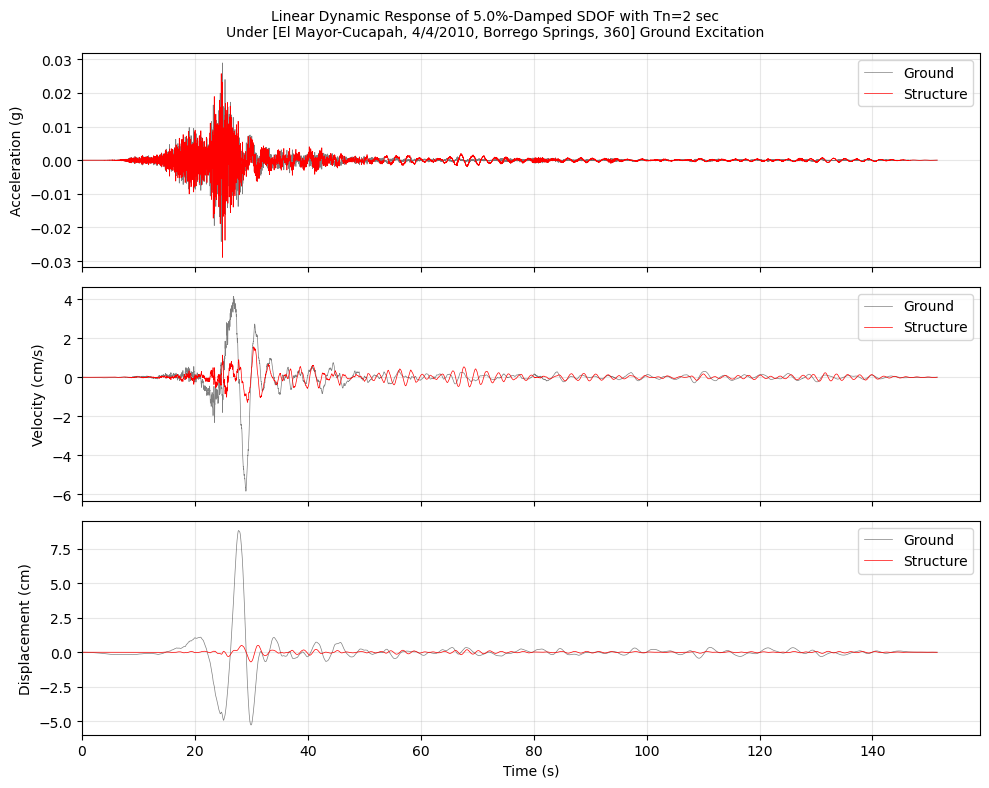

In [185]:
# Plot results
plt.style.use('default')  # Use default style instead of seaborn
fig, ax = plt.subplots(3, 1, sharex=True,figsize=(10, 8))

for i, key in enumerate(ground.keys()):
    ax[i].plot(t, ground[key], 'k-', label='Ground', alpha = 0.5, linewidth=0.5)
    if key == 'Acceleration':
        ax[i].plot(t, structure[key] / g, 'r-', label='Structure', linewidth=0.5)
    else:
        ax[i].plot(t, structure[key], 'r-', label='Structure', linewidth=0.5)
    ax[i].set_xlim(left=0)
    ax[i].set_ylabel(f'{key} ({header[key][-2].split()[-1].lower()})')
    ax[i].grid(True, alpha=0.3)
    ax[i].legend()

ax[-1].set_xlabel('Time (s)')
plt.suptitle(f"Linear Dynamic Response of {100*zeta}%-Damped SDOF with Tn={t_n} sec\nUnder [{title_lines[1]}] Ground Excitation", fontsize=10)
plt.tight_layout()
plt.show()

In [187]:
# System parameters
t_n_values = np.arange(0.05, 4.05, 0.05)  # natural periods from 0.1 to 10 sec
omega_n = 2 * np.pi / t_n_values # natural frequencies (rad/s)
zeta = 0.05  # damping ratio (5%)
g = 9.81 * 100  # gravitational acceleration (cm/s2)
# Time parameters
t = time['Acceleration']

# Create interpolation function for ground motion
acc_interp = interp1d(t, ground['Acceleration'] * g, bounds_error=False, fill_value=0.0)

# Pre-calculate ground acceleration for all time points
acc_t = acc_interp(t)

# Vectorized system equations
def sdof_system_vectorized(t_val, y, omega_n_array):
    # y shape is (2*n_periods, ) where first n_periods elements are displacements
    # and second n_periods elements are velocities
    n_periods = len(omega_n_array)
    
    # Reshape y into displacement and velocity arrays
    displacement = y[:n_periods]
    velocity = y[n_periods:]
    
    # Calculate derivatives
    d_displacement = velocity
    d_velocity = np.zeros_like(displacement)
    
    # Get current acceleration value using interpolation
    current_acc = acc_interp(t_val) if t_val < t[-1] else 0
    
    # Calculate d_velocity for each period
    for i in range(n_periods):
        d_velocity[i] = -omega_n_array[i]**2 * displacement[i] - \
                       2 * zeta * omega_n_array[i] * velocity[i] - \
                       current_acc
    
    return np.concatenate([d_displacement, d_velocity])

# Calculate natural frequencies
omega_n_array = 2 * np.pi / t_n_values

# Set up initial conditions for all periods at once
n_periods = len(t_n_values)
y0 = np.zeros(2 * n_periods)  # First n_periods zeros for displacement, second for velocity

# Solve the system for all periods at once
sol = solve_ivp(
    lambda t, y: sdof_system_vectorized(t, y, omega_n_array),
    t_span=[0, t[-1]],
    y0=y0,
    t_eval=t,
    method='RK45',
    rtol=1e-8,
    atol=1e-8
)

# Extract and organize results
n_time = len(t)
displacement = np.zeros((n_periods, n_time))
velocity = np.zeros((n_periods, n_time))
acceleration = np.zeros((n_periods, n_time))

for i in range(n_periods):
    displacement[i] = sol.y[i]
    velocity[i] = sol.y[i + n_periods]
    acceleration[i] = -omega_n_array[i]**2 * displacement[i] - \
                     2 * zeta * omega_n_array[i] * velocity[i] - \
                     ground['Acceleration'] * g

structure = {
    'Displacement': displacement,
    'Velocity': velocity,
    'Acceleration': acceleration
}


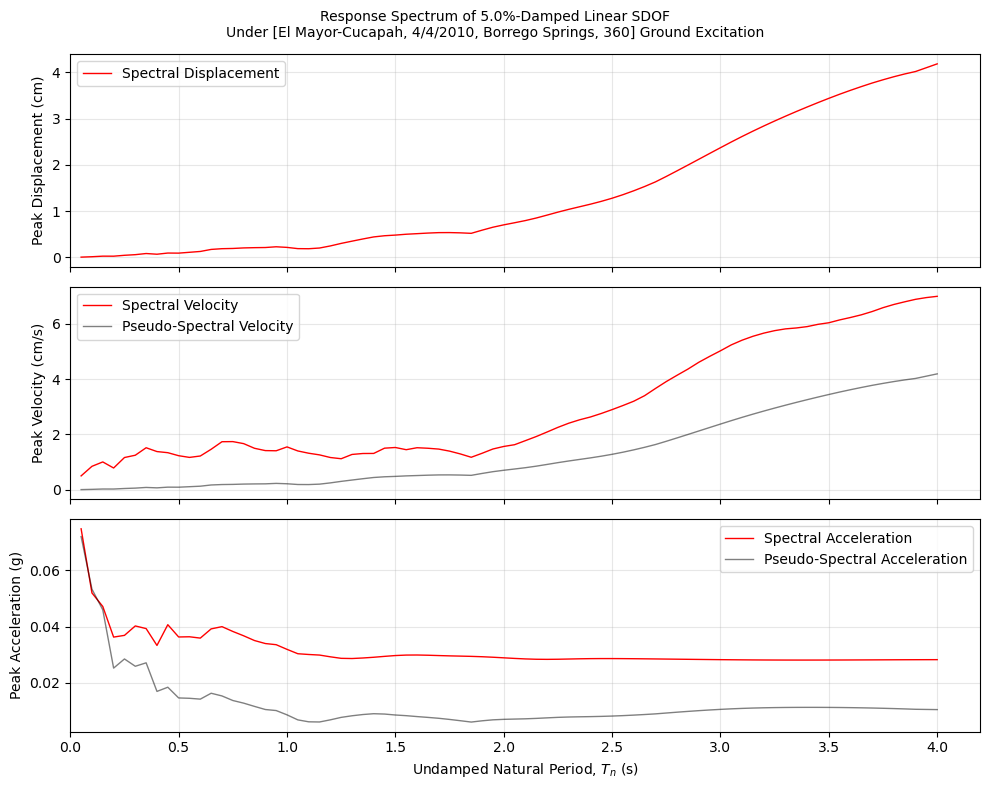

In [195]:

s_d = np.max(np.abs(structure['Displacement']), axis=1)

fig, ax = plt.subplots(3, 1, sharex=True, figsize=(10, 8))


for i, key in enumerate(structure.keys()):
    peak = np.max(np.abs(structure[key]), axis=1)

    if key == 'Acceleration':
        peak = peak / g
        s = s_d * np.power(omega_n, 2) / g
    elif key == 'Displacement':
        s = s_d * omega_n
    else:  # Displacement
        s = s_d
        
    ax[i].plot(t_n_values, peak, 'r-', linewidth=1, label=f'Spectral {key}')
    if key in ['Acceleration', 'Velocity']:
        ax[i].plot(t_n_values, s, 'k-', alpha=0.5, linewidth=1, label=f'Pseudo-Spectral {key}')
    ax[i].set_xlim(left=0)
    ax[i].grid(True, alpha=0.3)
    ax[i].set_ylabel(f'Peak {key} ({header[key][-2].split()[-1].lower()})')
    ax[i].legend()


ax[-1].set_xlabel('Undamped Natural Period, $T_n$ (s)')
plt.suptitle(f"Response Spectrum of {100*zeta}%-Damped Linear SDOF\nUnder [{title_lines[1]}] Ground Excitation", fontsize=10)
plt.tight_layout()
plt.show()
